In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline


In [ ]:
results = {}
# raw_results_fname = learned_batching_samples_more_data.txt"
raw_results_fname = "/Users/crankshaw/clipper/experiments_logs/replica_scaling"

with open(raw_results_fname, "r") as f:
    lines = f.readlines()
    for i in range(len(lines)):
#     for line in f.readlines():
        line = lines[i]
        if "GREPTHIS" in line:
            splits = line.strip().split("XXXXXX")
#             print splits[0]
            res = json.loads(splits[1].strip())
            results[res["name"]] = res
#             model = splits[-2]
#             s = "["
#             j = i + 1
#             while "]" not in line:
#                 line = lines[j]
#                 s += line
#                 j += 1
#             results[model] = json.loads(s)
#             i = j

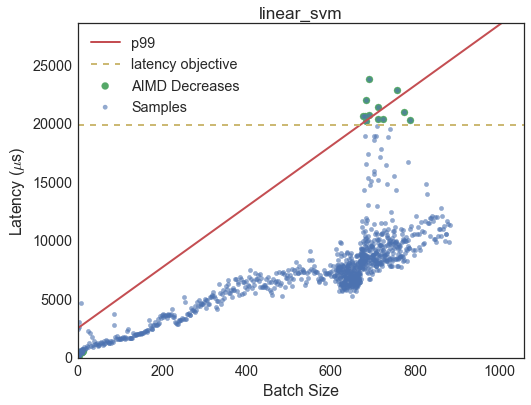

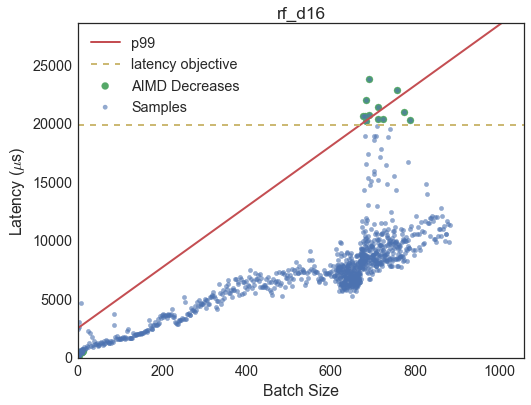

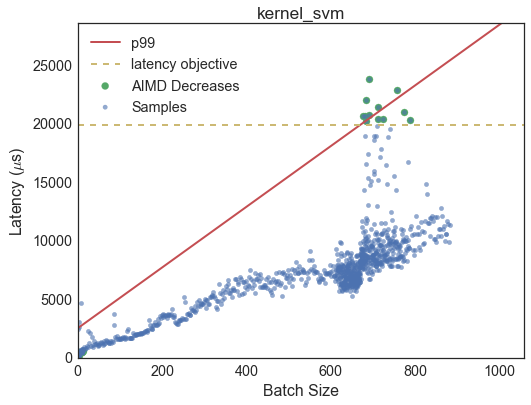

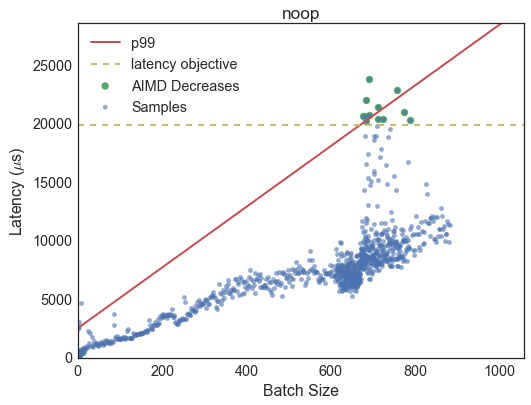

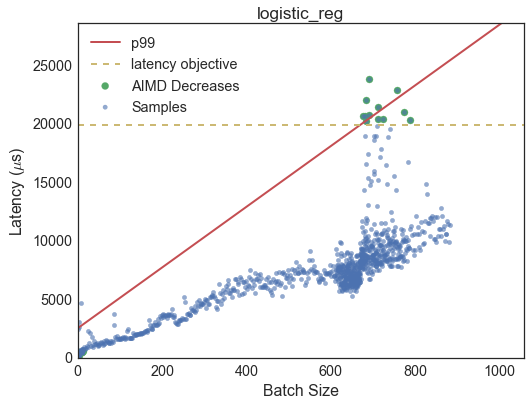

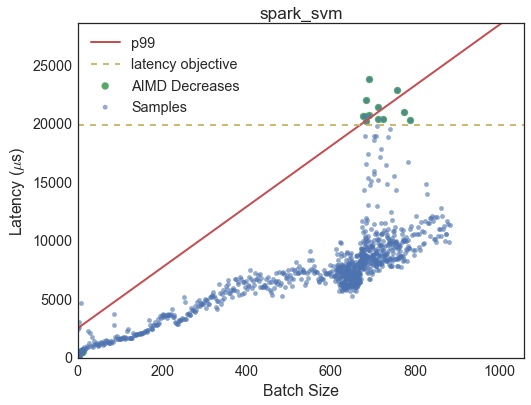

In [3]:
fig_dir = "/Users/crankshaw/model-serving/clipper_paper/ModelServingPaper/nsdi_2017/figs2"
sns.set_style("white")
sns.set_context("paper", font_scale=1.8,)


def find_backtrack_points(batches, lats):
    bt_batches = []
    bt_lats = []
    for i in range(len(batches) - 1):
        if batches[i] > batches[i + 1]:
            bt_batches.append(batches[i])
            bt_lats.append(lats[i])
    return (bt_batches, bt_lats)

def process_batch(results, name):
    splits = [(r["batch_size"], r["latency"]) for r in results["linear_svm"]["measurements"]]
    batches, latencies = zip(*splits)
    df = pd.DataFrame({"batch_size": batches, "latencies": latencies})
    
    # Fit the quantile regression line
    quantiles = [0.99]
    mod = smf.quantreg('latencies ~ batch_size', df)
    def fit_model(q):
        model_fit = mod.fit(q=q)
        return [q, model_fit.params['Intercept'], model_fit.params['batch_size']] + model_fit.conf_int().ix['batch_size'].tolist()    
    models = [fit_model(cur_q) for cur_q in quantiles]
    models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub']) 
    x_max_lim = np.max(batches)*1.2
    x = np.arange(0, x_max_lim, 1)
    colors = sns.color_palette("deep")
    fig, ax = plt.subplots(figsize=(8, 6))
    bt_batches, bt_lats = find_backtrack_points(batches, latencies)
    ax.scatter(bt_batches, bt_lats, color=colors[1], s=50, label="AIMD Decreases")
    lw=2
    ax.scatter(batches, latencies, color=colors[0], alpha=0.6, s=20, label="Samples")
    get_y = lambda a, b: a + b * x
    for i in range(models.shape[0]):
        y = get_y(models.a[i], models.b[i])
        ax.plot(x, y, linestyle='-', color=colors[2], linewidth=lw, label="p%d" % int(models.q[i]*100))
    ax.plot([0, x_max_lim], np.ones(2)*20000, color=colors[4], linestyle="dashed", linewidth=lw, label = "latency objective")
    ax.set_xlim((0, x_max_lim))
    ax.set_ylim((0, max(np.max(latencies)*1.2, 25000)))   
    legend = ax.legend(loc=0)
    ax.set_title(name)
    ax.set_ylabel("Latency ($\mu$s)")
    ax.set_xlabel("Batch Size")
    plt.savefig("%s/%s_batching_scatterplot.pdf" % (fig_dir,name), bbox_inches='tight')


results = {}
# raw_results_fname = learned_batching_samples_more_data.txt"
# raw_results_fname = "/Users/crankshaw/clipper/experiments_logs/batching_strat_comparison/DEBUG_learned_batching_160913-150515_logs.txt"
raw_results_fname = os.path.abspath("../results/batching_scatter_plots_raw_logs.txt")


with open(raw_results_fname, "r") as f:
    lines = f.readlines()
    for i in range(len(lines)):
        line = lines[i]
        if "GREPTHIS" in line:
            splits = line.strip().split("XXXXXX")
            res = json.loads(splits[1].strip())
            results[res["name"]] = res

for n in results.keys():
    process_batch(results, n)


In [ ]:

sns.set_style("white")
sns.set_context("paper", font_scale=1.8,)

def process_batch(name, batches, latencies):
#     quantiles = np.arange(0.09, 0.999, 0.1)
    quantiles = [0.99]
    
    
    df = pd.DataFrame({"batch_size": batches, "latencies": latencies})
#     print df.head()
    mod = smf.quantreg('latencies ~ batch_size', df)
    def fit_model(q):
        model_fit = mod.fit(q=q)
        return [q, model_fit.params['Intercept'], model_fit.params['batch_size']] + model_fit.conf_int().ix['batch_size'].tolist()    
    models = [fit_model(cur_q) for cur_q in quantiles]
    models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])
    
    ols = smf.ols('latencies ~ batch_size', df).fit()
    ols_ci = ols.conf_int().ix['batch_size'].tolist()
    ols = dict(a = ols.params['Intercept'],
               b = ols.params['batch_size'],
               lb = ols_ci[0],
               ub = ols_ci[1])
    
#     print models
#     print ols

    print results[model]["name"], results[model]["batch_size"]
#     fig, ax = plt.subplots(figsize=(8,6))
    
    
    x_max_lim = np.max(batches)*1.2
    x = np.arange(0, x_max_lim, 1)
    get_y = lambda a, b: a + b * x

    fig, ax = plt.subplots(figsize=(8, 6))
    lw=2
    ax.scatter(batches, latencies, alpha=0.3)
#     df = pd.DataFrame(data, columns=["x", "y"])
#     sns.jointplot(x="batch_size", y="latencies", data=df)
    for i in range(models.shape[0]):
        y = get_y(models.a[i], models.b[i])
        ax.plot(x, y, linestyle='-', color='red', linewidth=lw, label="p%d" % int(models.q[i]*100))
#         ax.plot(x, y, color='black')


    y = get_y(ols['a'], ols['b'])

#     ax.plot(x, y, color='red', label='OLS', linewidth=lw,)
    predicted_batch_size = results[model]["batch_size"]
#     ax.scatter(data.income, data.foodexp, alpha=.2)
#     ax.plot(np.ones(2)*predicted_batch_size, [0, 100000], color="blue", linewidth=lw, linestyle="dashed", label= "predicted batch size")
    ax.plot([0, x_max_lim], np.ones(2)*20000, color="green", linestyle="dashed", linewidth=lw, label = "latency objective")

    ax.set_xlim((0, x_max_lim))
    ax.set_ylim((0, max(np.max(latencies)*1.2, 25000)))
    
    
    
    
    
    legend = ax.legend(loc=0)
#     ax.set_xlabel('Income', fontsize=16)
#     ax.set_ylabel('Food expenditure', fontsize=16);
    ax.set_title(name)
    ax.set_ylabel("latency")
    ax.set_xlabel("batch size")
    fig_dir = "/Users/crankshaw/model-serving/clipper_paper/ModelServingPaper/nsdi_2017/figs2"
    plt.savefig("%s/%s_baching_scatterplot.pdf" % (fig_dir,name), bbox_inches='tight')

#     plt.show()



for model in results:
#     print results[model].keys()
    batches = []
    latencies = []
    for m in results[model]["measurements"]:
        latencies.append(m["latency"])
        batches.append(m["batch_size"])
    process_batch(model, batches, latencies)
    
    

In [ ]:
print results

In [ ]:
print results.keys()


In [ ]:
# print results["spark_svm"]["measurements"]
splits = [(r["batch_size"], r["latency"]) for r in results["spark_svm"]["measurements"][400:660]]
batches, lats = zip(*splits)
fig, ax = plt.subplots()
ax.plot(batches, lats)
ax.set_xlabel("batch size")
ax.set_ylabel("latency")
ax.set_title("AIMD Adaptive Batching")
fig_dir = "/Users/crankshaw/model-serving/clipper_paper/ModelServingPaper/nsdi_2017/figs2"

plt.savefig("%s/aimd_batching_illustration_spark_svm" % (fig_dir), bbox_inches='tight')



In [ ]:
def find_backtrack_points(batches, lats):
    bt_batches = []
    bt_lats = []
    for i in range(len(batches) - 1):
        if batches[i] > batches[i + 1]:
            bt_batches.append(batches[i])
            bt_lats.append(lats[i])
    return (bt_batches, bt_lats)
def plot_with_backtracks(name)
    name = "linear_svm"
    splits = [(r["batch_size"], r["latency"]) for r in results[name]["measurements"]]
    # print splits
    batches, lats = zip(*splits)
    fig, ax = plt.subplots()
    ax.scatter(batches, lats)
    bt_batches, bt_lats = find_backtrack_points(batches, lats)
    print bt_batches, bt_lats
    ax.scatter(bt_batches, bt_lats, color="red", s=50)

    ax.set_xlabel("batch size")
    ax.set_ylabel("latency")
    ax.set_xlim(-50, 1000)

    ax.set_title("AIMD Adaptive Batching: %s" % (" ".join(name.split("_")).title()))
    fig_dir = "/Users/crankshaw/model-serving/clipper_paper/ModelServingPaper/nsdi_2017/figs2"

    plt.savefig("%s/aimd_batching_illustration_%s.pdf" % (fig_dir, name), bbox_inches='tight')
for n in results.keys():
    plot_with_backtracks(n)

In [ ]:
splits = [(r["batch_size"], r["latency"]) for r in results["linear_svm"]["measurements"]]
batches, lats = zip(*splits)
def find_backtrack_points(batches, lats):
    bt_idxs = []
    for i in range(len(batches) - 1):
        if batches[i] > batches[i + 1]:
            bt_idxs.append(i)
    return bt_idxs
print find_backtrack_points(batches, lats)